In [222]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from pprint import pprint
%matplotlib inline

In [118]:
start = datetime(2004,1,1)
end = datetime(2010,1,1)

In [94]:
amzn = pdr.get_data_yahoo('AMZN', start, end)
amzn.drop(['Close', 'Volume'], axis=1, inplace=True)

In [95]:
amzn.columns = ['Open', 'High', 'Low', 'Close'] # Adj Close -> Close

In [96]:
amzn.head()

,Open,High,Low,Close
Date,,,,
2004-01-02,52.759998,53.130001,51.430000,51.900002
2004-01-05,52.000000,53.599998,51.369999,53.270000
2004-01-06,53.110001,53.500000,52.740002,53.029999
2004-01-07,52.180000,52.660000,50.939999,51.900002
2004-01-08,52.090000,52.099998,50.029999,50.240002


### Create percentage change list

In [117]:
amzn_pct = amzn.pct_change().fillna(0)

In [121]:
scaler = StandardScaler()
amzn_pct = scaler.fit_transform(amzn_pct)

In [123]:
amzn_pct = pd.DataFrame(amzn_pct, columns=amzn.columns, index=amzn.index)

In [124]:
amzn_pct.head()

,Open,High,Low,Close
Date,,,,
2004-01-02,-0.036005,-0.035846,-0.036729,-0.035600
2004-01-05,-0.511426,0.271798,-0.078504,0.817943
2004-01-06,0.668511,-0.100727,0.918247,-0.181281
2004-01-07,-0.613938,-0.581878,-1.258847,-0.724615
2004-01-08,-0.092931,-0.405675,-0.676409,-1.069822


### Check volatility

In [135]:
amzn_roll = amzn.rolling(window=30)

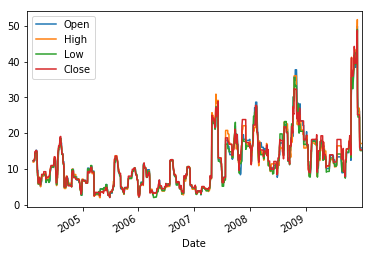

In [136]:
(amzn_roll.max()-amzn_roll.min()).plot()

### Check they are the same length

In [108]:
len(amzn) - len(amzn_pct)

0

In [236]:
class TradeDTO:
    
    BUY = 'buy'
    SELL = 'sell'
    
    def __init__(self, pct_data, enter_day, exit_day, direction, hold_days, price_diff):
        self.pct_data = pct_data
        self.enter_day = enter_day
        self.exit_day = exit_day
        self.direction = direction
        self.hold_days = hold_days
        self.price_diff = price_diff
        
    def __repr__(self):
        return 'From {} to {} | enter {} | exit {} | {} | {} hold days | {} diff'.format(
            self.pct_data.iloc[0].name.date(),
            self.pct_data.iloc[-1].name.date(),
            self.enter_day.name.date(),
            self.exit_day.name.date(),
            self.direction,
            self.hold_days,
            self.price_diff)

### Parameters for trade collecting

In [233]:
min_hold_days = 1
max_hold_days = 5
window = 30

In [240]:
positions = []
for i in range(window, len(amzn)-max_hold_days):
    from_idx = i - window
    to_idx = i + 1
    pct_data_part = amzn_pct.iloc[from_idx:to_idx]
    
    current_day = amzn.iloc[i]
    
    future_from_idx = i+min_hold_days
    future_to_idx = i+max_hold_days
    
    check_data_part = amzn.iloc[future_from_idx:future_to_idx]
    max_ev_date = np.argmax(np.abs(current_day['Close'] - check_data_part['Close']))
    target_day = check_data_part.loc[max_ev_date]
    
    day_diff = len(amzn[current_day.name:target_day.name]) - 1
    price_diff = target_day['Close'] - current_day['Close']
    direction = TradeDTO.BUY if price_diff > 0 else TradeDTO.SELL
    #print('- {} days: {} to {}'.format(str(day_diff), current_day.name.date(), target_day.name.date()))
    trade = TradeDTO(pct_data_part, current_day, target_day, direction, day_diff, price_diff)
    positions.append(trade)

In [241]:
pprint(positions)

[From 2004-01-02 to 2004-02-17 | enter 2004-02-17 | exit 2004-02-23 | sell | 4 hold days | -1.5599979999999931 diff,
 From 2004-01-05 to 2004-02-18 | enter 2004-02-18 | exit 2004-02-24 | sell | 4 hold days | -2.5499989999999997 diff,
 From 2004-01-06 to 2004-02-19 | enter 2004-02-19 | exit 2004-02-24 | sell | 3 hold days | -2.3300020000000004 diff,
 From 2004-01-07 to 2004-02-20 | enter 2004-02-20 | exit 2004-02-24 | sell | 2 hold days | -2.8499979999999994 diff,
 From 2004-01-08 to 2004-02-23 | enter 2004-02-23 | exit 2004-02-24 | sell | 1 hold days | -1.6500010000000032 diff,
 From 2004-01-09 to 2004-02-24 | enter 2004-02-24 | exit 2004-02-26 | buy | 2 hold days | 1.3300020000000004 diff,
 From 2004-01-12 to 2004-02-25 | enter 2004-02-25 | exit 2004-03-02 | sell | 4 hold days | -0.9300010000000043 diff,
 From 2004-01-13 to 2004-02-26 | enter 2004-02-26 | exit 2004-03-02 | sell | 3 hold days | -1.6400040000000047 diff,
 From 2004-01-14 to 2004-02-27 | enter 2004-02-27 | exit 2004-03-0

 From 2005-12-05 to 2006-01-19 | enter 2006-01-19 | exit 2006-01-25 | sell | 4 hold days | -0.850003000000001 diff,
 From 2005-12-06 to 2006-01-20 | enter 2006-01-20 | exit 2006-01-26 | buy | 4 hold days | 0.7600020000000001 diff,
 From 2005-12-07 to 2006-01-23 | enter 2006-01-23 | exit 2006-01-27 | buy | 4 hold days | 1.4900010000000066 diff,
 From 2005-12-08 to 2006-01-24 | enter 2006-01-24 | exit 2006-01-27 | buy | 3 hold days | 1.2000010000000003 diff,
 From 2005-12-09 to 2006-01-25 | enter 2006-01-25 | exit 2006-01-27 | buy | 2 hold days | 1.620003000000004 diff,
 From 2005-12-12 to 2006-01-26 | enter 2006-01-26 | exit 2006-02-01 | sell | 4 hold days | -0.7000000000000028 diff,
 From 2005-12-13 to 2006-01-27 | enter 2006-01-27 | exit 2006-02-02 | sell | 4 hold days | -2.4799989999999994 diff,
 From 2005-12-14 to 2006-01-30 | enter 2006-01-30 | exit 2006-02-03 | sell | 4 hold days | -6.629996999999996 diff,
 From 2005-12-15 to 2006-01-31 | enter 2006-01-31 | exit 2006-02-06 | sell 

 From 2008-01-09 to 2008-02-22 | enter 2008-02-22 | exit 2008-02-28 | sell | 4 hold days | -4.230004000000008 diff,
 From 2008-01-10 to 2008-02-25 | enter 2008-02-25 | exit 2008-02-29 | sell | 4 hold days | -8.799996000000007 diff,
 From 2008-01-11 to 2008-02-26 | enter 2008-02-26 | exit 2008-03-03 | sell | 4 hold days | -9.260002000000007 diff,
 From 2008-01-14 to 2008-02-27 | enter 2008-02-27 | exit 2008-03-03 | sell | 3 hold days | -8.440002999999997 diff,
 From 2008-01-15 to 2008-02-28 | enter 2008-02-28 | exit 2008-03-03 | sell | 2 hold days | -5.419998 diff,
 From 2008-01-16 to 2008-02-29 | enter 2008-02-29 | exit 2008-03-03 | sell | 1 hold days | -2.0400009999999966 diff,
 From 2008-01-17 to 2008-03-03 | enter 2008-03-03 | exit 2008-03-04 | buy | 1 hold days | 2.9099959999999996 diff,
 From 2008-01-18 to 2008-03-04 | enter 2008-03-04 | exit 2008-03-06 | sell | 2 hold days | -2.5999939999999953 diff,
 From 2008-01-22 to 2008-03-05 | enter 2008-03-05 | exit 2008-03-06 | sell | 1 h

 From 2009-07-10 to 2009-08-21 | enter 2009-08-21 | exit 2009-08-26 | sell | 3 hold days | -1.0 diff,
 From 2009-07-13 to 2009-08-24 | enter 2009-08-24 | exit 2009-08-28 | sell | 4 hold days | -1.739998 diff,
 From 2009-07-14 to 2009-08-25 | enter 2009-08-25 | exit 2009-08-31 | sell | 4 hold days | -3.0 diff,
 From 2009-07-15 to 2009-08-26 | enter 2009-08-26 | exit 2009-09-01 | sell | 4 hold days | -4.839995999999999 diff,
 From 2009-07-16 to 2009-08-27 | enter 2009-08-27 | exit 2009-09-02 | sell | 4 hold days | -6.16999899999999 diff,
 From 2009-07-17 to 2009-08-28 | enter 2009-08-28 | exit 2009-09-02 | sell | 3 hold days | -4.620002999999997 diff,
 From 2009-07-20 to 2009-08-31 | enter 2009-08-31 | exit 2009-09-02 | sell | 2 hold days | -3.050003000000004 diff,
 From 2009-07-21 to 2009-09-01 | enter 2009-09-01 | exit 2009-09-08 | buy | 4 hold days | 1.739998 diff,
 From 2009-07-22 to 2009-09-02 | enter 2009-09-02 | exit 2009-09-09 | buy | 4 hold days | 4.099998999999997 diff,
 From 2